Click the button above to load the interactive widgets

In [41]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit, fsolve

from IPython.display import Image
from ipywidgets import interact
from ipywidgets import fixed, ToggleButtons, IntSlider, FloatSlider, Dropdown, SelectMultiple, Layout

from pandas.tseries.offsets import Week
%matplotlib inline

<b> Preface </b>
    
    Here are being condensed few simple models and data visualization tools that capture my attention in literature. The idea is to play around with it and understand how important is to limit social contact in this period, and also the importance of modelling for understanding and timely actions.

# Load data from JHU

In [42]:
def loadData(fileName):
    data = pd.read_csv(baseURL + fileName) \
             .drop(['Lat', 'Long'], axis=1) #\
#              .melt(id_vars=['Province/State', 'Country/Region'], 
#                  var_name='date', value_name=columnName) \
#              .astype({'date':'datetime64[ns]', columnName:'Int64'}, 
#                  errors='ignore')
    data['Province/State'].fillna('<all>', inplace=True)
#     data[columnName].fillna(0, inplace=True)
    return data

In [43]:
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

In [44]:
Confirmed = loadData("time_series_covid19_confirmed_global.csv")

# Structure dataset

In [45]:
# grouping by country
Confirmed = Confirmed.groupby(['Country/Region']).sum()

In [46]:
Confirmed = Confirmed.T

In [47]:
Confirmed.index = pd.to_datetime(Confirmed.index)

# Logistic model

Inspired by https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

In [48]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [49]:
def logistic_covid(covid19_df, nation):
    """
    df: dataframe of covid19 data with nations as columns and timestamp as index
    nation: string
    
    """
    df = covid19_df[nation]
    
    x = list(df.reset_index().index)
    y = list(df.values)
    
#     Real data
    plt.scatter(x, y, label="Real data", color="red")
    
#     fit data
    fit = curve_fit(logistic_model, x, y,p0=[50,100,20000])
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2]

#     print('Infection speed '+str(round(a)))
    print('Maximum infections occurred on '+str(pd.to_datetime(df.index[0]) + pd.to_timedelta(round(b), unit='D')))
    print('Total predicted infected '+str(round(c))+ ' +-'+str(round(errors[2])))

    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    pred_x = list(range(max(x),sol))

    # Mdel data
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model");

# Run logistic model

Fitting a logistic model on total cases of a country. Select the country and check the predicted peak of infections and total population

In [50]:
interact(logistic_covid, 
         covid19_df = fixed(Confirmed),
         nation = Dropdown(options=list(Confirmed.columns), value='Italy'));

interactive(children=(Dropdown(description='nation', index=84, options=('Afghanistan', 'Albania', 'Algeria', '…

# SIR Model definition

Inspired by https://www.linkedin.com/pulse/covid-19-from-model-prediction-predictive-control-ingmar-nopens/

In [51]:
def model_der(variables, t, beta, gamma):

    S = variables[0]
    I = variables[1]
    R = variables[2]
    
    S_new = -beta*I*S 
    I_new = beta*I*S - gamma*I
    R_new = gamma*I
    return [S_new, I_new, R_new]

In [52]:
def SIRmodel_logbeta2(timesteps, S_0, I_0, R_0, log10_beta, gamma, measured_cases, country, returnDataFrame=True, plotFig=True):
    """
    implementation of SIR population model
    
    Parameters
    -----------
    timesteps : np.array
    country: string
    log10_beta: float <0
    gamma: float
    
    """
    
    modeloutput = odeint(model_der, [S_0, I_0, R_0], timesteps, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=timesteps)
    
    modeloutput.index = pd.date_range(start='1/20/2020', periods=len(timesteps))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,8))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(measured_cases[country], 'rx')
        axes.plot(modeloutput);
#         measured_cases[country].plot(axes=axes)
        
    if returnDataFrame:
        return modeloutput 

# Run SIR model

Try to fir the SIR model to the cases of a specific country and compare it to the logistic model

In [53]:
interact(SIRmodel_logbeta2, 
         
         timesteps=fixed(np.arange(0., 1000, 1)), 
         
         country = Dropdown(options=list(Confirmed.columns), value='US'),
         
         measured_cases = fixed(Confirmed),
         
         S_0=FloatSlider(value=500000, 
                           min=Confirmed.max().mean(), 
                           max=5*Confirmed.max().max(), 
                           step=1000,
                           continuous_update=False,
                           description='Affected population'), 
         I_0=fixed(1), R_0=fixed(0),
         
         log10_beta=FloatSlider(value=-6.3, min=-8, max=-5, step=0.001,
                                continuous_update=True, readout_format='.2e',
                               description='log10(infection rate)'),
         
         gamma=FloatSlider(value=0.06, min=0, max=0.06, step=0.001,
                           continuous_update=False, readout_format='.2e',
                          description='Recovery rate'),
         returnDataFrame=fixed(False));
# axes.plot(COVID19_totalConf, 'rx')

interactive(children=(FloatSlider(value=500000.0, continuous_update=False, description='Affected population', …

# LogLog visualization (when are we on our way out of pandemic)

Inspired by https://t.co/q2AtUQBX5P?amp=1

In [54]:
Confirmedweeklyrates = (Confirmed - Confirmed.shift(1, freq=Week()).reindex(Confirmed.index)).fillna(value=0)

In [55]:
def plot_infectionrate(Confirmedweeklyrates, country, return_plot = True, return_df=False):
    """
    Confirmed_rate: rate of infection adjusted from JHU
    country: string
    """
    country = list(country)
    res = Confirmed_Wrate[country]
    if return_plot is True:
        res.plot()
    if return_df is True:
        return(res);

In [71]:
def loglog_covid(Confirmedweeklyrates, countries):
    """
    Confirmed: df adjustedc from JHU
    countries: list in columns of Confirmed
    
    """
    fig, axes = plt.subplots(figsize=(15,8))
    
    df = Confirmedweeklyrates[list(countries)]

    axes.loglog(Confirmed.sum(axis=1), df.values, 'o')
    axes.legend(countries)
    axes.set_title('Loglog')
    axes.set_ylabel('Weekly increase of positive cases')
    axes.set_xlabel('Total cases globally')
    axes.set_xlim([1e4,1e7])

## Visualization of infection rate (weekly new cases)

Check the rate of infections for one or multiple countries

In [65]:
interact(plot_infectionrate,
         Confirmedweeklyrates = fixed(Confirmedweeklyrates),
         country = SelectMultiple(options=list(Confirmedweeklyrates.columns), value=['Belgium', 'Italy', 'Spain', 'US'],
                                  description='Select country(ies)',
                                  style = {'description_width': 'initial'},
                                  layout=Layout(width='40%', height='100px')),
         return_df = fixed(False),
         return_plot = fixed(True));

interactive(children=(SelectMultiple(description='Select country(ies)', index=(16, 84, 154, 169), layout=Layou…

## loglog plot

Inspired by https://t.co/q2AtUQBX5P?amp=1

A smart way of visualizing how effective are the measures taken from each country to limit the infection rate. When the Y axis values drop significantly, this means that the spreading of the infections is sensibly decreased.

In [72]:
interact(loglog_covid,
         Confirmedweeklyrates = fixed(Confirmedweeklyrates),
         countries = SelectMultiple(options=list(Confirmed.columns), value=['Belgium', 'Italy', 'Spain', 'US'],
                                 description='Select countries (Ctrl+ for multi-selection)', 
                                    style = {'description_width': 'initial'},
                                    layout=Layout(width='50%', height='200px')),
         return_df= fixed(False));

interactive(children=(SelectMultiple(description='Select countries (Ctrl+ for multi-selection)', index=(16, 84…

## loglog plot (alternative to facilitate widgets)

In [59]:
Confirmedweeklyrates = (Confirmed - Confirmed.shift(1, freq=Week()).reindex(Confirmed.index)).fillna(value=0)

In [60]:
def loglog_covid2(Confirmedweeklyrates, countries):
    """
    Confirmed: df adjustedc from JHU
    countries: list in columns of Confirmed
    
    """
    fig, axes = plt.subplots(figsize=(15,8))
    

    axes.loglog(Confirmed.sum(axis=1), Confirmedweeklyrates[countries].values, 'o')
    axes.legend(countries)
    axes.set_title('Loglog')
    axes.set_ylabel('Weekly increase of positive cases')
    axes.set_xlabel('Total cases globally')
    axes.set_xlim([1e4,1e7])

interactive(children=(SelectMultiple(description='Select countries (Ctrl+ for multi-selection)', index=(16, 84…

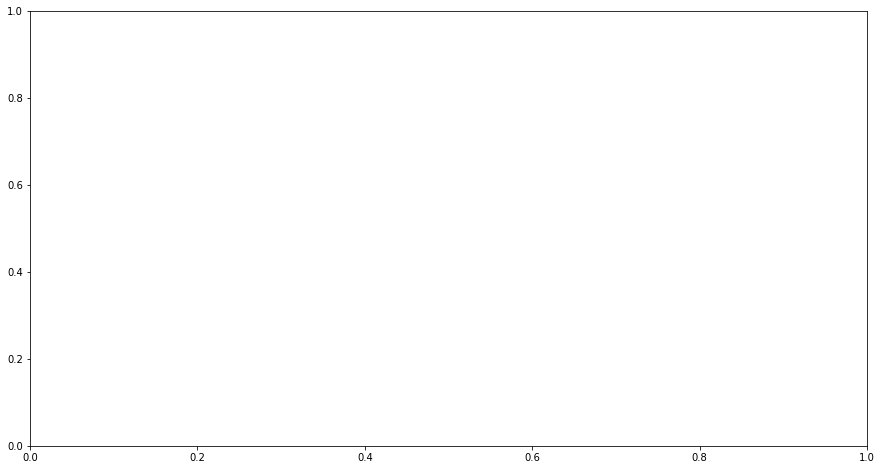

In [63]:
interact(loglog_covid2,
         Confirmedweeklyrates = fixed(Confirmedweeklyrates),
         countries = SelectMultiple(options=list(Confirmed.columns), value=['Belgium', 'Italy', 'Spain', 'US'],
                                 description='Select countries (Ctrl+ for multi-selection)', 
                                    style = {'description_width': 'initial'},
                                    layout=Layout(width='50%', height='200px')),
         return_df= fixed(False));